In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [7]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [8]:
ny_data = newyork_data['features']

In [12]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude


### We will get New York data such as Borough, Neighborhood and Latitude, Longitude

In [17]:

for data in ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
   

In [18]:
 neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Getting coordinates of Queens, New York for further use

In [21]:
address = 'Queens, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


### Using Foursquare Location Data for further analysis

In [22]:
CLIENT_ID = '5ROCVQZ3VOHGPZUX1ANPLAMEGIYYZZM1BCV0KUG5S0FKX3Q1' # your Foursquare ID
CLIENT_SECRET = '5OAZIN50SLEDEEXOD144NINCLENWXWM3QNFSTFUOA121I3ND'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ROCVQZ3VOHGPZUX1ANPLAMEGIYYZZM1BCV0KUG5S0FKX3Q1
CLIENT_SECRET:5OAZIN50SLEDEEXOD144NINCLENWXWM3QNFSTFUOA121I3ND


In [24]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [27]:
queens_data.loc[0, 'Neighborhood']

'Astoria'

In [28]:
neighborhood_latitude = queens_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queens_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = queens_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Astoria are 40.76850859335492, -73.91565374304234.


In [29]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=5ROCVQZ3VOHGPZUX1ANPLAMEGIYYZZM1BCV0KUG5S0FKX3Q1&client_secret=5OAZIN50SLEDEEXOD144NINCLENWXWM3QNFSTFUOA121I3ND&v=20180605&ll=40.76850859335492,-73.91565374304234&radius=500&limit=100'

In [ ]:
results = requests.get(url).json()
results

In [31]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Favela Grill,Brazilian Restaurant,40.767348,-73.917897
1,Orange Blossom,Gourmet Shop,40.769856,-73.917012
2,Off The Hook,Seafood Restaurant,40.767200,-73.918104
3,CrossFit Queens,Gym,40.769404,-73.918977
4,Titan Foods Inc.,Gourmet Shop,40.769198,-73.919253


In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge
Astoria
Woodside
Jackson Heights
Elmhur

In [38]:
print(queens_venues.shape)
queens_venues.head()

(8364, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop


In [39]:
queens_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,80,80,80,80,80,80
Astoria,400,400,400,400,400,400
Astoria Heights,44,44,44,44,44,44
Auburndale,72,72,72,72,72,72
Bay Terrace,152,152,152,152,152,152
Bayside,300,300,300,300,300,300
Bayswater,4,4,4,4,4,4
Beechhurst,64,64,64,64,64,64
Bellaire,44,44,44,44,44,44


In [42]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 273 uniques categories.


### Exploring the different Businesses in the Neighborhood

In [45]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Summer Camp,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women'

In [47]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Summer Camp,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women'

### Finding the No. of Indian Restaurant in the Neighborhood

In [59]:
Indian_restaurant = queens_grouped[['Neighborhood', 'Indian Restaurant']]
Indian_restaurant.head()

,Neighborhood,Indian Restaurant
0,Arverne,0.00
1,Astoria,0.04
2,Astoria Heights,0.00
3,Auburndale,0.00
4,Bay Terrace,0.00


In [54]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

print('Libraries imported.')

Libraries imported.


### Clustering the Neighborhood

In [66]:
kclusters = 5

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 0, 0, 0, 0, 0, 3, 0, 0, 2], dtype=int32)

In [67]:
def unique(list1): 
    x = np.array(list1) 
    print(np.unique(x))
unique(kmeans.labels_)    

[0 1 2 3 4]


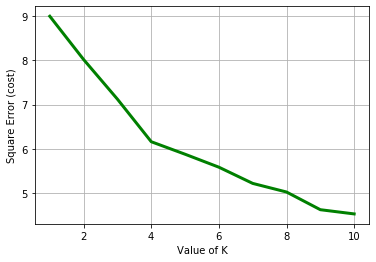

In [61]:
cost= []
for i in range (1,11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(queens_grouped_clustering)
    
    cost.append(KM.inertia_)
    
plt.plot(range(1,11), cost,color='g', linewidth='3')
plt.xlabel("Value of K")
plt.ylabel("Square Error (cost)")
plt.grid()
plt.show()

In [69]:
# add clustering labels
Indian_restaurant.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(Indian_restaurant.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Queens,Astoria,40.768509,-73.915654,0,0.04
1,Queens,Woodside,40.746349,-73.901842,0,0.00
2,Queens,Jackson Heights,40.751981,-73.882821,0,0.00
3,Queens,Elmhurst,40.744049,-73.881656,0,0.00
4,Queens,Howard Beach,40.654225,-73.838138,0,0.00


In [97]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [98]:
# Cluster 0
queens_merged.loc[queens_merged['Cluster Labels']==0].head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
0,Queens,Astoria,40.768509,-73.915654,0,0.040000
1,Queens,Woodside,40.746349,-73.901842,0,0.000000
2,Queens,Jackson Heights,40.751981,-73.882821,0,0.000000
3,Queens,Elmhurst,40.744049,-73.881656,0,0.000000
4,Queens,Howard Beach,40.654225,-73.838138,0,0.000000
5,Queens,Corona,40.742382,-73.856825,0,0.000000
6,Queens,Forest Hills,40.725264,-73.844475,0,0.000000
7,Queens,Kew Gardens,40.705179,-73.829819,0,0.045455
8,Queens,Richmond Hill,40.697947,-73.831833,0,0.047619
9,Queens,Flushing,40.764454,-73.831773,0,0.000000


In [99]:
# Cluster 1
queens_merged.loc[queens_merged['Cluster Labels']==1].head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
63,Queens,Somerville,40.597711,-73.796648,1,0.0
144,Queens,Somerville,40.597711,-73.796648,1,0.0
225,Queens,Somerville,40.597711,-73.796648,1,0.0
306,Queens,Somerville,40.597711,-73.796648,1,0.0


In [75]:
# Cluster 2
queens_merged.loc[queens_merged['Cluster Labels']==2].head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
15,Queens,Glendale,40.702762,-73.870742,2,0.0
17,Queens,Woodhaven,40.689887,-73.858110,2,0.0
19,Queens,South Ozone Park,40.668550,-73.809865,2,0.0
21,Queens,Whitestone,40.781291,-73.814202,2,0.0
30,Queens,Briarwood,40.710935,-73.811748,2,0.1
41,Queens,Far Rockaway,40.603134,-73.754980,2,0.0
42,Queens,Broad Channel,40.603027,-73.820055,2,0.0
61,Queens,Belle Harbor,40.576156,-73.854018,2,0.0
64,Queens,Brookville,40.660003,-73.751753,2,0.0
66,Queens,North Corona,40.754071,-73.857518,2,0.0


In [100]:
# Cluster 3
queens_merged.loc[queens_merged['Cluster Labels']==3].head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Indian Restaurant
79,Queens,Bayswater,40.611322,-73.765968,3,0.0
160,Queens,Bayswater,40.611322,-73.765968,3,0.0
241,Queens,Bayswater,40.611322,-73.765968,3,0.0
322,Queens,Bayswater,40.611322,-73.765968,3,0.0


## Visualization
### No. Of Neighborhood for each Borough in New York city

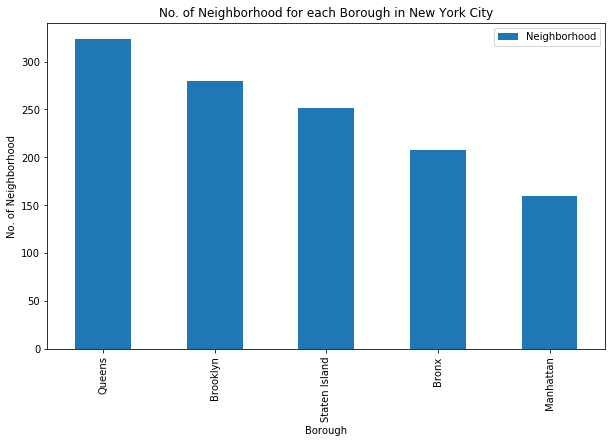

In [96]:

graph = pd.DataFrame(neighborhoods.groupby(['Borough'])['Neighborhood'].count())
graph = graph.sort_values(by='Neighborhood', ascending= False)
graph.iloc[:10].plot(kind='bar', figsize=(10,6))
plt.xlabel("Borough") 
plt.ylabel("No. of Neighborhood") 
plt.title("No. of Neighborhood for each Borough in New York City") 
plt.show()


### Distribution of Indian Restaurants across different Neighborhoods

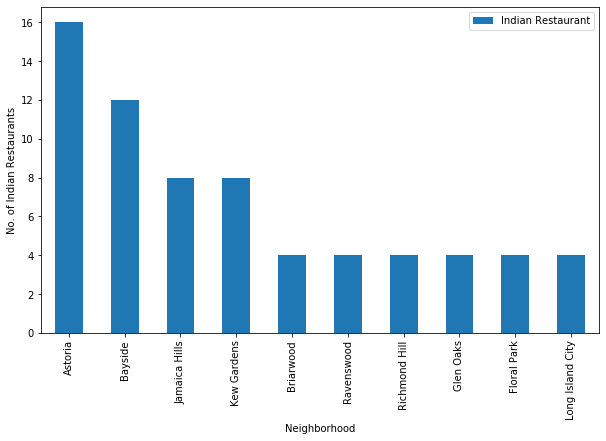

In [80]:
graph = pd.DataFrame(queens_onehot.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by='Indian Restaurant', ascending= False)
graph.iloc[:10].plot(kind='bar', figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('No. of Indian Restaurants')
plt.show()